In [ ]:

import torch
from mantis.models.intern_vl_25_8b import InternVLChatProcessor, InternLM2Tokenizer
attention_file = "./scripts/attention_mochi_g8_f8.pt"
input_ids_file = "./scripts/input_ids_mochi_g8_f8.pt"   
# Load attention tensor
attentions = torch.load(attention_file)
input_ids = torch.load(input_ids_file)

print(f"Number of attentions: {len(attentions)}")
print(f"len(attentions[0]): {len(attentions[0])}")
print(f"attentions[0][0].shape: {attentions[0][0].shape}")
print(f"attentions[0][1].shape: {attentions[0][1].shape}")
print(f"input_ids.shape: {input_ids.shape}")
local_self_attn = [x[0].mean(dim=(0, 1)) for x in attentions]
text_to_kv_attn = [x[1].mean(dim=(0, 1)) for x in attentions]
model_path = 'OpenGVLab/InternVL2_5-8B'
tokenizer = InternLM2Tokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)
processor = InternVLChatProcessor(tokenizer, enable_cross_attention=True, max_num_patches=1)

assert input_ids.shape[0] == 1, "Only support batch size 1"
selected = (input_ids == processor.img_context_token_id) | (input_ids == processor.img_start_token_id) | (input_ids == processor.img_end_token_id) | (input_ids == processor.bos_token_id)
reranged_input_ids = torch.cat([input_ids[selected], input_ids[~selected]])
tokens = tokenizer.convert_ids_to_tokens(reranged_input_ids)
max_token_len = max(len(token) for token in tokens)

/home/dongfu/miniconda3/envs/mantis/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/dongfu/WorkSpace/Mantis/ipykernel_761038/2069912779.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

Number of attentions: 32
len(attentions[0]): 2
attentions[0][0].shape: torch.Size([1, 32, 2065, 2065])
attentions[0][1].shape: torch.Size([1, 32, 93, 2158])


In [50]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
from tqdm import tqdm
from pathlib import Path

def plot_heatmap(attn: torch.Tensor, save_path="./fig.png", title="Attention Heatmap", vmin=None, vmax=None):
    # Convert mean attention tensor to numpy array
    attention_data = attn.float().cpu().numpy()
    print(f"attention_data.shape: {attention_data.shape}")
    q_len, k_len = attention_data.shape
    
    q_size = max(int(q_len // 100), 2)
    k_size = max(int(k_len // 100), 6)
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(k_size, q_size))
    print(f"figsize: {fig.get_size_inches()}")

    # Create heatmap with log scaling
    heatmap = ax.imshow(attention_data, cmap='viridis', aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax))  

    # Add colorbar
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label('Attention Weight (Log Scale)')

    # Set labels and title
    ax.set_xlabel('KV Tokens')
    ax.set_ylabel('Query Tokens')
    ax.set_title(title)

    # Save the plot
    plt.show()
    plt.close()

num_higher_weights: 344
sum of weights: tensor(1., dtype=torch.bfloat16)
idx attention weights
1    -> <s>          : 0.46289062
2    -> <img>        : 0.04614258
3    -> <IMG_CONTEXT>: 0.00708008
4    -> <IMG_CONTEXT>: 0.00543213
5    -> <IMG_CONTEXT>: 0.00314331
6    -> <IMG_CONTEXT>: 0.00154114
7    -> <IMG_CONTEXT>: 0.00097275
8    -> <IMG_CONTEXT>: 0.00172424
9    -> <IMG_CONTEXT>: 0.00646973
10   -> <IMG_CONTEXT>: 0.00253296
11   -> <IMG_CONTEXT>: 0.00222778
12   -> <IMG_CONTEXT>: 0.00083923
13   -> <IMG_CONTEXT>: 0.00035286
14   -> <IMG_CONTEXT>: 0.00099182
15   -> <IMG_CONTEXT>: 0.00300598
16   -> <IMG_CONTEXT>: 0.00046921
17   -> <IMG_CONTEXT>: 0.00054550
18   -> <IMG_CONTEXT>: 0.00329590
19   -> <IMG_CONTEXT>: 0.00297546
20   -> <IMG_CONTEXT>: 0.00114441
21   -> <IMG_CONTEXT>: 0.00081253
22   -> <IMG_CONTEXT>: 0.00024796
23   -> <IMG_CONTEXT>: 0.00027657
24   -> <IMG_CONTEXT>: 0.00019550
25   -> <IMG_CONTEXT>: 0.00154877
26   -> <IMG_CONTEXT>: 0.00081253
27   -> <IMG_CONTEXT>

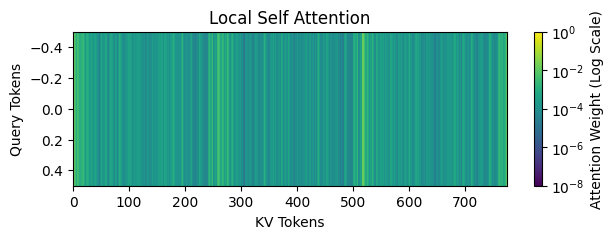

In [141]:
k =  516 + 258 
layer_idx = 31
if k >= local_self_attn[layer_idx].shape[0]:
    weights = text_to_kv_attn[layer_idx][k, :k+1]
else:
    weights = local_self_attn[layer_idx][k, :k+1]
    delta_weights = weights - local_self_attn[layer_idx][k-1, :k+1]
    print(f"num_higher_weights: {(delta_weights > 0).sum()}")
print("sum of weights:", weights.sum())     
print("idx attention weights")
for i, (token, weight) in enumerate(zip(tokens, weights)):
    token_id = str(i+1).ljust(len(str(len(tokens))))
    print(f"{token_id} -> {token.ljust(max_token_len)}: {weight:.8f}")
vmin = 1e-8
vmax = 1
print(f"vmin: {vmin}, vmax: {vmax}")
plot_heatmap(local_self_attn[layer_idx][k, :k+1].unsqueeze(0), title="Local Self Attention", vmin=vmin, vmax=vmax)

num_higher_weights: 267
sum of weights: tensor(0.5625, dtype=torch.bfloat16)
delta of sum of weights: tensor(0.5273, dtype=torch.bfloat16)
Current token that is attended: 775 </img>
idx attention weights

775  -> </img>       : 0.00224304
776  -> <img>        : 0.00271606
777  -> <IMG_CONTEXT>: 0.00231934
778  -> <IMG_CONTEXT>: 0.00199890
779  -> <IMG_CONTEXT>: 0.00256348
780  -> <IMG_CONTEXT>: 0.00209045
781  -> <IMG_CONTEXT>: 0.00224304
782  -> <IMG_CONTEXT>: 0.00376892
783  -> <IMG_CONTEXT>: 0.00750732
784  -> <IMG_CONTEXT>: 0.00555420
785  -> <IMG_CONTEXT>: 0.00372314
786  -> <IMG_CONTEXT>: 0.00238037
787  -> <IMG_CONTEXT>: 0.00218201
788  -> <IMG_CONTEXT>: 0.00228882
789  -> <IMG_CONTEXT>: 0.00215149
790  -> <IMG_CONTEXT>: 0.00241089
791  -> <IMG_CONTEXT>: 0.00288391
792  -> <IMG_CONTEXT>: 0.00274658
793  -> <IMG_CONTEXT>: 0.00179291
794  -> <IMG_CONTEXT>: 0.00129700
795  -> <IMG_CONTEXT>: 0.00129700
796  -> <IMG_CONTEXT>: 0.00182343
797  -> <IMG_CONTEXT>: 0.00305176
798  -> <IMG_

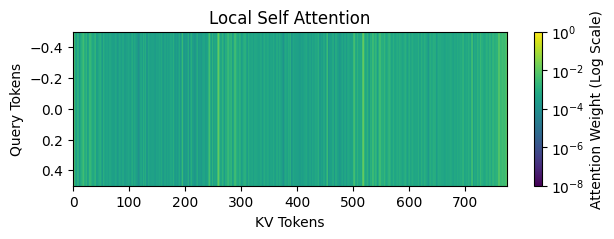

In [ ]:
k =  516 + 258
offset = 1024
layer_idx = 0
if k >= local_self_attn[layer_idx].shape[0]:
    weights = text_to_kv_attn[layer_idx][k+offset:, k]
else:
    weights = local_self_attn[layer_idx][k+offset:, k]
    delta_weights = weights - local_self_attn[layer_idx][k+offset:, k-1] if k > 0 else weights
    print(f"num_higher_weights: {(delta_weights > 0).sum()}")
cur_tokens = tokens[k:]
print("sum of weights:", weights.sum())
print("delta of sum of weights:", delta_weights.sum())
print("Current token that is attended:", k+1, cur_tokens[0])
print("idx attention weights")
print()
for i, (token, weight) in enumerate(zip(cur_tokens, weights)):
    token_id = k + i
    token_id = str(token_id+1).ljust(len(str(len(tokens))))
    print(f"{token_id} -> {token.ljust(max_token_len)}: {weight:.8f}")
vmin = 1e-8
vmax = 1
print(f"vmin: {vmin}, vmax: {vmax}")
plot_heatmap(local_self_attn[layer_idx][k, :k+1].unsqueeze(0), title="Local Self Attention", vmin=vmin, vmax=vmax)

In [ ]:
layer_idx = 0
top_k_to_print = 300
# analysis the tokens where the later tokens always have consistent attention weights
to_attend_weights_deltas = {}
for i in range(len(local_self_attn[layer_idx])):
    weights = local_self_attn[layer_idx][i, :i+1] # lower, the more biased the current token will attend to the previous tokens
    to_attend_weights_deltas[i] = weights.std().item()
    # to_attend_weights_deltas[i] = ((weights - local_self_attn[layer_idx][i-1, :i+1] if i > 0 else weights) > 0).sum().item()   # higher, the more previous tokens this token attends to 
    to_attend_weights_deltas[i] /= len(weights)

sorted_to_attend_weights_deltas = sorted(to_attend_weights_deltas.items(), key=lambda x: x[1], reverse=False)
print(f"Top {top_k_to_print} tokens with the highest variance of attention weights")
for i, (idx, var) in enumerate(sorted_to_attend_weights_deltas[:top_k_to_print]):
    print(f"{idx} -> {tokens[idx].ljust(max_token_len)}: {var:.8f}")

Top 300 tokens with the highest variance of attention weights
0 -> <s>          : nan
1807 -> <img>        : 0.00000144
2064 -> </img>       : 0.00000174
1549 -> <img>        : 0.00000199
1806 -> </img>       : 0.00000225
1291 -> <img>        : 0.00000286
1548 -> </img>       : 0.00000307
2048 -> <IMG_CONTEXT>: 0.00000411
1290 -> </img>       : 0.00000440
1033 -> <img>        : 0.00000440
1790 -> <IMG_CONTEXT>: 0.00000508
2049 -> <IMG_CONTEXT>: 0.00000515
1532 -> <IMG_CONTEXT>: 0.00000645
1032 -> </img>       : 0.00000677
1791 -> <IMG_CONTEXT>: 0.00000688
1823 -> <IMG_CONTEXT>: 0.00000696
2001 -> <IMG_CONTEXT>: 0.00000704
2000 -> <IMG_CONTEXT>: 0.00000714
1837 -> <IMG_CONTEXT>: 0.00000714
2016 -> <IMG_CONTEXT>: 0.00000729
2054 -> <IMG_CONTEXT>: 0.00000737
2063 -> <IMG_CONTEXT>: 0.00000751
1854 -> <IMG_CONTEXT>: 0.00000760
775 -> <img>        : 0.00000771
1895 -> <IMG_CONTEXT>: 0.00000773
1829 -> <IMG_CONTEXT>: 0.00000777
1845 -> <IMG_CONTEXT>: 0.00000787
1984 -> <IMG_CONTEXT>: 0.000007

/home/dongfu/WorkSpace/Mantis/ipykernel_761038/771369350.py:7: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  to_attend_weights_deltas[i] = weights.std().item() / (i+1)


In [ ]:
layer_idx = 31
top_k_to_print = 500
# analysis the tokens where the later tokens always have consistent attention weights
to_attend_weights_deltas = {}
for i in range(len(local_self_attn[layer_idx])):
    weights = local_self_attn[layer_idx][i:, i] # lower, the more biased the current token will attend to the previous tokens
    # to_attend_weights_deltas[i] = weights.std().item()
    to_attend_weights_deltas[i] = weights.std().item() + weights.sum().item()
    # to_attend_weights_deltas[i] = ((weights - local_self_attn[layer_idx][i:, i-1] if i > 0 else weights) > 0).sum().item() # higher, the more previous tokens this token attends to 
    # to_attend_weights_deltas[i] = weights.sum().item() # higher, the more important this token is to the later tokens
    to_attend_weights_deltas[i] /= len(weights)

sorted_to_attend_weights_deltas = sorted(to_attend_weights_deltas.items(), key=lambda x: x[1], reverse=True)
print(f"Top {top_k_to_print} tokens with the highest variance of attention weights")
for i, (idx, var) in enumerate(sorted_to_attend_weights_deltas[:top_k_to_print]):
    print(f"{idx} -> {tokens[idx].ljust(max_token_len)}: {var:.8f}")



Top 500 tokens with the highest variance of attention weights
0 -> <s>          : 0.41262461
2063 -> <IMG_CONTEXT>: 0.18139648
2061 -> <IMG_CONTEXT>: 0.04235840
2062 -> <IMG_CONTEXT>: 0.03181966
2060 -> <IMG_CONTEXT>: 0.02890625
2059 -> <IMG_CONTEXT>: 0.02758789
2057 -> <IMG_CONTEXT>: 0.02110291
2054 -> <IMG_CONTEXT>: 0.02058549
2049 -> <IMG_CONTEXT>: 0.01850891
2058 -> <IMG_CONTEXT>: 0.01508440
2051 -> <IMG_CONTEXT>: 0.01356724
2048 -> <IMG_CONTEXT>: 0.01213523
2050 -> <IMG_CONTEXT>: 0.01212565
2055 -> <IMG_CONTEXT>: 0.01191406
2038 -> <IMG_CONTEXT>: 0.01158764
2052 -> <IMG_CONTEXT>: 0.01155912
2053 -> <IMG_CONTEXT>: 0.01108805
2032 -> <IMG_CONTEXT>: 0.00916082
2047 -> <IMG_CONTEXT>: 0.00870768
2056 -> <IMG_CONTEXT>: 0.00806342
2039 -> <IMG_CONTEXT>: 0.00790171
2043 -> <IMG_CONTEXT>: 0.00789573
2046 -> <IMG_CONTEXT>: 0.00717645
1 -> <img>        : 0.00709129
2044 -> <IMG_CONTEXT>: 0.00707427
2042 -> <IMG_CONTEXT>: 0.00706946
2029 -> <IMG_CONTEXT>: 0.00693427
2040 -> <IMG_CONTEXT>: 0.0

/home/dongfu/WorkSpace/Mantis/ipykernel_761038/4232781853.py:8: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  to_attend_weights_deltas[i] = weights.std().item() + weights.sum().item()


In [245]:
layer_idx = 31
top_k_to_print = 500
# test whether keeping the top_k_to_print tokens can help reproduce the attention weights of each tokens
top_k_idxs = [idx for idx, _ in sorted_to_attend_weights_deltas[:top_k_to_print]]
reproduced_weights = []
for i in range(len(local_self_attn[layer_idx])):
    weights = local_self_attn[layer_idx][i, top_k_idxs] # lower, the more biased the current token will attend to the previous tokens
    reproduced_weights.append(weights.sum().item())
    # reproduced_weights.append(weights.sum().item())
# print(reproduced_weights)
print(f"local attn error:", (1 - torch.tensor(reproduced_weights)).abs().mean().item())
# print("sum of reproduced weights:", sum(reproduced_weights))

# test whether keeping the top_k_to_print tokens can help reproduce the attention weights of each tokens
_top_k_idxs = [idx for idx, _ in sorted_to_attend_weights_deltas[:top_k_to_print]] + [i+local_self_attn[layer_idx].shape[0] for i in range(text_to_kv_attn[layer_idx].shape[0])] 
reproduced_weights = []
for i in range(len(text_to_kv_attn[layer_idx])):
    weights = text_to_kv_attn[layer_idx][i, _top_k_idxs] # lower, the more biased the current token will attend to the previous tokens
    reproduced_weights.append(weights.sum().item())
    # reproduced_weights.append(weights.sum().item())
# print(reproduced_weights)
print(f"text to kv error:", (1 - torch.tensor(reproduced_weights)).abs().mean().item())
# print("sum of reproduced weights:", sum(reproduced_weights))

local attn error: 0.39080092310905457
text to kv error: 0.0851394459605217


In [226]:
layer_idx = 31
top_k_to_print = 300
# analysis the tokens where the later tokens always have consistent attention weights
to_attend_weights_deltas = {}
for i in range(len(local_self_attn[layer_idx])):
    weights = text_to_kv_attn[layer_idx][:, i]
    # to_attend_weights_deltas[i] = weights.std().item()
    to_attend_weights_deltas[i] = weights.std().item() + weights.sum().item()
    # to_attend_weights_deltas[i] = ((weights - text_to_kv_attn[layer_idx][:, i-1] if i > 0 else weights) > 0).sum().item() # higher, the more previous tokens this token attends to 
    # to_attend_weights_deltas[i] = weights.sum().item() # higher, the more important this token is to the later tokens
    to_attend_weights_deltas[i] /= len(weights)

sorted_to_attend_weights_deltas = sorted(to_attend_weights_deltas.items(), key=lambda x: x[1], reverse=True)
print(f"Top {top_k_to_print} tokens with the highest variance of attention weights")
for i, (idx, var) in enumerate(sorted_to_attend_weights_deltas[:top_k_to_print]):
    print(f"{idx} -> {tokens[idx].ljust(max_token_len)}: {var:.8f}")
    
# test whether keeping the top_k_to_print tokens can help reproduce the attention weights of each tokens
top_k_idxs = [idx for idx, _ in sorted_to_attend_weights_deltas[:top_k_to_print]]
reproduced_weights = []
for i in range(len(local_self_attn[layer_idx])):
    weights = local_self_attn[layer_idx][i, top_k_idxs] # lower, the more biased the current token will attend to the previous tokens
    reproduced_weights.append(weights.sum().item())
    # reproduced_weights.append(weights.sum().item())
# print(reproduced_weights)
print(f"local attn error:", (1 - torch.tensor(reproduced_weights)).abs().mean().item())
# print("sum of reproduced weights:", sum(reproduced_weights))

# test whether keeping the top_k_to_print tokens can help reproduce the attention weights of each tokens
_top_k_idxs = [idx for idx, _ in sorted_to_attend_weights_deltas[:top_k_to_print]] + [i+local_self_attn[layer_idx].shape[0] for i in range(text_to_kv_attn[layer_idx].shape[0])] 
reproduced_weights = []
for i in range(len(text_to_kv_attn[layer_idx])):
    weights = text_to_kv_attn[layer_idx][i, _top_k_idxs] # lower, the more biased the current token will attend to the previous tokens
    reproduced_weights.append(weights.sum().item())
    # reproduced_weights.append(weights.sum().item())
# print(reproduced_weights)
print(f"text to kv error:", (1 - torch.tensor(reproduced_weights)).abs().mean().item())
# print("sum of reproduced weights:", sum(reproduced_weights))


Top 300 tokens with the highest variance of attention weights
0 -> <s>          : 0.40690629
1 -> <img>        : 0.00924715
248 -> <IMG_CONTEXT>: 0.00244625
9 -> <IMG_CONTEXT>: 0.00243960
259 -> <img>        : 0.00212712
2 -> <IMG_CONTEXT>: 0.00197462
1864 -> <IMG_CONTEXT>: 0.00194558
1544 -> <IMG_CONTEXT>: 0.00184910
17 -> <IMG_CONTEXT>: 0.00177913
8 -> <IMG_CONTEXT>: 0.00159963
24 -> <IMG_CONTEXT>: 0.00150676
83 -> <IMG_CONTEXT>: 0.00150414
3 -> <IMG_CONTEXT>: 0.00145910
275 -> <IMG_CONTEXT>: 0.00136283
506 -> <IMG_CONTEXT>: 0.00120089
257 -> <IMG_CONTEXT>: 0.00118645
14 -> <IMG_CONTEXT>: 0.00116722
67 -> <IMG_CONTEXT>: 0.00106262
517 -> <img>        : 0.00104740
5 -> <IMG_CONTEXT>: 0.00104687
4 -> <IMG_CONTEXT>: 0.00100556
1825 -> <IMG_CONTEXT>: 0.00098608
243 -> <IMG_CONTEXT>: 0.00091930
533 -> <IMG_CONTEXT>: 0.00091528
791 -> <IMG_CONTEXT>: 0.00085650
1022 -> <IMG_CONTEXT>: 0.00084752
7 -> <IMG_CONTEXT>: 0.00082012
1280 -> <IMG_CONTEXT>: 0.00081594
40 -> <IMG_CONTEXT>: 0.00079100
